In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')


In [2]:
import collections
import copy
from pprint import pprint
from typing import List

import numpy as np
import torch as th
import torch.nn.functional as thf

from rl.algs import environment
from rl.algs import model
from rl.algs import util



Sars = environment.SARS

class ReplayBuffer:
  def __init__(self, size=10000):
    self.max_size = size
    self.buf = [None] * self.max_size
    self.i = 0
    self.size = 0

  def add(self, entry):
    self.buf[self.i] = entry
    self.i = (self.i + 1) % self.max_size
    if self.size < self.max_size:
      self.size += 1

  def sample(self, n=1):
    """Samples n entries uniformly at random, without replacement."""
    assert n <= self.size
    idxs = np.random.choice(self.size, n, replace=False)
    entries = [self.buf[i] for i in idxs]
    return entries


class Dqn:
  def __init__(self, model, lr, eps_sched, target_update_freq=10000):
    self.model = model
    self.target_model = copy.deepcopy(self.model)
    self.optimizer = th.optim.Adam(self.model.parameters(), lr)
    self.eps_sched = eps_sched
    self.target_update_freq = target_update_freq
    self.gamma = 0.99
    self.step = 0

  def action_values(self, obs_np):
    obs_var = util.to_variable(obs_np)
    return self.model(obs_var)
  
  def get_action(self, obs_np):
    qs = self.action_values(obs_np)
    probs = thf.softmax(qs, dim=-1)
    probs = util.to_numpy(probs)
    return util.sample_eps_greedy(probs, self.eps_sched.get(self.step))

  def _update_step_params(self):
    self.step += 1
    if self.step % self.target_update_freq == 0:
      #print(f'step {self.step}: updating target model')
      #print(f'eps: {self.eps_sched.get(self.step)}')
      self.target_model = copy.deepcopy(self.model)

  def update(self, sars_batch: List[Sars]):
    metrics = {}
    self._update_step_params()
    bs = len(sars_batch)
    empty = np.zeros_like(sars_batch[0].s)
    s_batch = np.stack([sars.s for sars in sars_batch])
    a_batch = np.stack([sars.a for sars in sars_batch])
    r_batch = util.to_variable(np.stack([sars.r for sars in sars_batch]))
    s1_batch = np.stack([sars.s1 if sars.s1 is not None else empty
                         for sars in sars_batch])
    
    terminal_mask = util.to_variable(
        np.stack([1 if sars.s1 is None else 0 for sars in sars_batch]))
    
    a_var = util.to_variable(a_batch, dtype=th.LongTensor).unsqueeze(dim=1)
    
    qs = self.action_values(s_batch)
    qs_sel = th.gather(qs, dim=-1, index=a_var)
    
    s1_var = util.to_variable(s1_batch, volatile=True)
    target_qs = self.target_model(s1_var)
    target_qs_max, qs_max_idx = th.max(target_qs, dim=-1)
    target = self.gamma * terminal_mask * target_qs_max
    target += r_batch

    loss = thf.mse_loss(qs_sel, target)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    
    metrics['loss'] = util.to_numpy(loss)[0]
    return metrics
    
    


In [12]:
# Train the DQN

from rl.algs import experiment

BATCH_SIZE = 32
TRAIN_START_STEP = 100
NUM_TRAIN_STEPS = 200000
REPLAY_SIZE = 5000


env = environment.AtariEnvironment('Breakout')
model_params = {
}
policy_params = {
    'lr': 0.005,
    'eps_sched': util.Schedule((0, TRAIN_START_STEP, NUM_TRAIN_STEPS),
                               (1, 1, 0.1)),
    'target_update_freq': 1000,
}
exp = experiment.Experiment(env, model.QNetwork, model_params,
                            Dqn, policy_params)


rb = ReplayBuffer(REPLAY_SIZE)

for step in range(TRAIN_START_STEP):
  sars = env.step(exp.policy.get_action)
  rb.add(sars)

for step in range(TRAIN_START_STEP, NUM_TRAIN_STEPS):
  sars = env.step(exp.policy.get_action)
  rb.add(sars)
  experience_batch = rb.sample(BATCH_SIZE)
  m = exp.policy.update(experience_batch)
  if step % 500 == 0:
    print(f'Step: {step}; loss: {m["loss"]}')
    
def debug():
  for i in range(4):
    pyplot.figure()
    pyplot.imshow(env.last_obs[i, :, :], cmap='gray')

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Step: 500; loss: 8.67045164341107e-05
Step: 1000; loss: 0.00010578925866866484
Step: 1500; loss: 9.354373469250277e-05
Step: 2000; loss: 1.7775348169379868e-05
Step: 2500; loss: 0.030549798160791397
Step: 3000; loss: 0.00010811176616698503
Step: 3500; loss: 0.031276166439056396
Step: 4000; loss: 7.003571226960048e-06
Step: 4500; loss: 3.901989839505404e-05
Step: 5000; loss: 8.769686246523634e-06
Step: 5500; loss: 4.7233999794116244e-05
Step: 6000; loss: 4.62558591607376e-06
Step: 6500; loss: 7.008868851698935e-05
Step: 7000; loss: 3.2054704206530005e-05
Step: 7500; loss: 0.00012739849626086652
Step: 8000; loss: 3.5169457987649366e-05
Step: 8500; loss: 1.694915226835292e-05
Step: 9000; loss: 0.00017815487808547914
Step: 9500; loss: 0.0002959122066386044
Step: 10000; loss: 1.4976360944274347e-05
Step: 10500; loss: 9.967227379092947e-05
Step: 11000; loss: 0.0001555578492116183
Step: 11500; loss: 0.03132355958223343
Step: 12000; loss: 0.0004009358526673168
Step: 12500; loss: 0.000118556927

Step: 100500; loss: 0.030735371634364128
Step: 101000; loss: 0.0002753920271061361
Step: 101500; loss: 2.6325738872401416e-05
Step: 102000; loss: 9.550950198899955e-05
Step: 102500; loss: 9.838803089223802e-05
Step: 103000; loss: 1.9119990611216053e-05
Step: 103500; loss: 1.6171796232811175e-05
Step: 104000; loss: 6.72093010507524e-05
Step: 104500; loss: 0.00017348774417769164
Step: 105000; loss: 0.03145001828670502
Step: 105500; loss: 0.00010920783097390085
Step: 106000; loss: 1.4329498299048282e-05
Step: 106500; loss: 0.03164493665099144
Step: 107000; loss: 5.766302638221532e-05
Step: 107500; loss: 0.03127219155430794
Step: 108000; loss: 5.597872586804442e-06
Step: 108500; loss: 5.353752931114286e-05
Step: 109000; loss: 0.0312635712325573
Step: 109500; loss: 0.03060961328446865
Step: 110000; loss: 6.675773875031155e-06
Step: 110500; loss: 0.0630304142832756
Step: 111000; loss: 7.335822738241404e-05
Step: 111500; loss: 0.031244652345776558
Step: 112000; loss: 8.348397386725992e-05
Ste

Step: 198500; loss: 4.381549661047757e-05
Step: 199000; loss: 9.507096365268808e-06
Step: 199500; loss: 0.00011966974125243723


In [ ]:
env.visualize(exp.policy, steps=600)

[2 0 3 4 1]


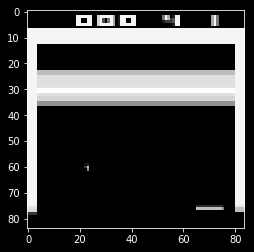

In [10]:
print(np.random.choice(5, 5, replace=False))
def show(sars):
  pyplot.figure()
  pyplot.imshow(sars.s[0, :, :], cmap='gray')

show(rb.sample()[0])


In [61]:
dqn = Dqn()
dqn.get_action(np.random.rand(210))

test_sars = [
    Sars(np.random.rand(210), 3, 0, np.random.rand(210)),
    Sars(np.random.rand(210), 0, 1, None),
    Sars(np.random.rand(210), 2, 2, np.random.rand(210)),
    Sars(np.random.rand(210), 1, 3, None)
]
dqn.update(test_sars)



In [78]:
rb = ReplayBuffer(5)
[rb.add(c) for c in 'abcdef']
print(rb.sample(2))

qs = np.random.rand(5, 4)
actions = np.array([0, 2, 1, 3, 0], dtype=np.int)
pprint(qs)
pprint(actions)
pprint(qs[range(5), actions])
qs[[False, True, True, False, True], :] = 0
pprint(qs)

['f', 'c']
array([[0.54102279, 0.90586718, 0.33795042, 0.78032276],
       [0.30351326, 0.70604155, 0.98818081, 0.04975847],
       [0.43589021, 0.99924586, 0.77265579, 0.15717228],
       [0.85018242, 0.05662995, 0.83276985, 0.37340199],
       [0.07857284, 0.86944281, 0.60107863, 0.9752491 ]])
array([0, 2, 1, 3, 0])
array([0.54102279, 0.98818081, 0.99924586, 0.37340199, 0.07857284])
array([[0.54102279, 0.90586718, 0.33795042, 0.78032276],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.85018242, 0.05662995, 0.83276985, 0.37340199],
       [0.        , 0.        , 0.        , 0.        ]])


In [10]:
from skimage import color
rgb = np.zeros((2, 1, 3))
rgb[1, 0, :] = 1
color.rgb2yuv(rgb)[:, :, 0]
x, y = np.random.rand(2, 3), np.random.rand(2, 3)
pprint((x, y, np.maximum(x, y)))

(array([[0.5917257 , 0.50399713, 0.35883697],
       [0.32559733, 0.71055613, 0.83439692]]),
 array([[0.60927262, 0.2183909 , 0.34192333],
       [0.03653836, 0.81768947, 0.4716851 ]]),
 array([[0.60927262, 0.50399713, 0.35883697],
       [0.32559733, 0.81768947, 0.83439692]]))


In [30]:
from rl.algs import util

s = util.Schedule((0, 100, 100, 200), (1, 1, 0.5, 0))
s.get(150)

0.25